# PA003: Churn Predict

# 0.0 Import

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math

from IPython.core.display          import HTML
from scipy.stats import shapiro, chi2_contingency

from sklearn                       import preprocessing            as pp

# from sklearn.preprocessing import StandardScaler, MinMaxScaler , RobustScaler


import warnings

warnings.filterwarnings("ignore")

## 0.1.Helper function

In [2]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [3]:
 def numerical_descriptive_statistical(num_attributes):
        
    """
    Shows the main values  for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
            
    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis, Shapiro-Wilk Test
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    return m



def categorical_descriptive_statstical(data , col):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([object]): Insert all categorical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with absolute and percent values
    """
    return pd.DataFrame({'absolute' : data[col].value_counts() , 'percent %': data[col].value_counts(normalize = True) * 100})

In [4]:
def correlation_matrix(data , method):
    """Generates a correlation matrix of numerical variables

    Args:correlation_matrix
        data ([DataFrame]): [The dataframe of the EDA]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes( include = ['int64' , 'float64'])
    correlation = num_attributes.corr( method = method)
#     correlation.append('exited')
    
#     df_corr = data[correlation].reset_index(drop=True)
#     df_corr['exited'] = df_corr['exited'].astype('int')
    
    # mask
    mask = np.zeros_like(correlation)
    mask = np.triu(np.ones_like(correlation , dtype = np.bool))
    
    # plot -  mask = mask ,
    ax = sns.heatmap(correlation , fmt = '.2f' , vmin = -1 , vmax = 1, annot =  True, cmap = 'YlGnBu' , square = True)
    
    return ax

In [5]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)

def plot_cat_overview(df, cat_attributes, target):
    
    cat_attributes.remove(target)
    plots_lin = math.ceil(len(cat_attributes)/2)
    
    fig, axs = plt.subplots(plots_lin,2, figsize=(25, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.20)
    axs = axs.ravel()    

    for c in range(len(cat_attributes)):
        ax1 = sns.countplot(ax=axs[c], x=cat_attributes[c],hue=target, data=df)
        without_hue(ax1,df1.exited)

In [6]:
def sum_of_na (data):
    return pd.DataFrame({'Sum of NA' : data.isna().sum(), '% NA': data.isna().sum()/data.shape[0]})

In [7]:
def lift_score(y, y_pred, **kwargs):    
    df = pd.DataFrame()
    df['true'] = y
    df['pred'] = y_pred
    df.sort_values('pred', ascending=False, inplace=True)
    N = len(df)
    churn_total = df['true'].sum() / N
    n = int(np.ceil(.1 * N)) 
    data_here = df.iloc[:n, :]
    churn_here = data_here['true'].sum() / n
    lift = churn_here / churn_total
    return lift

In [8]:
 def knapsack(W, wt, val):
    n = len(val)
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    keep = [False] * n
    res = max_val
    w = W
    for i in range(n, 0, -1):
        if res <= 0: break
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

## 0.2. Loading Data

In [9]:
df_raw = pd.read_csv(r'~/repositorio/churn_predict/data/raw/churn.csv')

In [10]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


# 1.0. Data Description


 - **RowNumber**      : O número da coluna.
 - **CustomerID**     : Identificador único do cliente.
 - **Surname**        : Sobrenome do cliente.
 - **CreditScore**    : A pontuação de Crédito do cliente para o mercado de consumo.
 - **Geography**      : O país onde o cliente reside.
 - **Gender**         : O gênero do cliente.
 - **Age**            : A idade do cliente.
 - **Tenure**         : Número de anos que o cliente permaneceu ativo.
 - **Balance**        : Valor monetário que o cliente tem em sua conta bancária.
 - **NumOfProducts**  : O número de produtos comprado pelo cliente no banco.
 - **HasCrCard**      : Indica se o cliente possui ou não cartão de crédito.
 - **IsActiveMember** : Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
 - **EstimateSalary** : Estimativa do salário mensal do cliente.
 - **Exited**         : Indica se o cliente está ou não em Churn.

In [11]:
df1 = df_raw.copy()

In [12]:
df1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [13]:
df1.duplicated('CustomerId').sum() 

0

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 1.1 Rename Columns

In [15]:
old_columns=list(df1.columns)

snakecase = lambda x : inflection.underscore(x)
new_columns = map(snakecase , old_columns)

# rename columns
df1.columns = new_columns


## 1.2. Data Dimensions

In [16]:
print('Numbers of rows: {}'.format(df1.shape[0]))
print('Numbers of cols: {}'.format(df1.shape[1]))

Numbers of rows: 10000
Numbers of cols: 14


## 1.3. Data Types

In [17]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

### 1.3.1. Change Data Types

In [18]:
df1.exited = df1.exited.astype('bool')
df1.has_cr_card = df1.has_cr_card.astype('bool')
df1.is_active_member= df1.is_active_member.astype('bool')

### 1.3.2. Check unique values

In [19]:
df1.nunique()

row_number          10000
customer_id         10000
surname              2932
credit_score          460
geography               3
gender                  2
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

### 1.3.3. Remove Variables

In [20]:
cols_drop = ['row_number', 'surname', 'customer_id']
df1 = df1.drop(cols_drop , axis = 1)

## 1.4. Check NA

In [21]:
df1.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Data Descriptive

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1. Numerical Attributes


In [23]:
m = numerical_descriptive_statistical(num_attributes)
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,shapiro
0,credit_score,350.0,850.0,500.0,650.529,652.0,96.648,-0.072,-0.426,not normal
1,age,18.0,92.0,74.0,38.922,37.0,10.487,1.011,1.395,not normal
2,tenure,0.0,10.0,10.0,5.013,5.0,2.892,0.011,-1.165,not normal
3,balance,0.0,250898.09,250898.09,76485.889,97198.54,62394.285,-0.141,-1.489,not normal
4,num_of_products,1.0,4.0,3.0,1.53,1.0,0.582,0.746,0.583,not normal
5,estimated_salary,11.58,199992.48,199980.9,100090.24,100193.915,57507.617,0.002,-1.182,not normal


### 1.5.2. Categorical Attributes


In [24]:
cat_attributes.columns

Index(['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited'], dtype='object')

In [25]:
x = df1[['geography' , 'exited']].groupby('geography').count().reset_index()
x

,geography,exited
0,France,5014
1,Germany,2509
2,Spain,2477


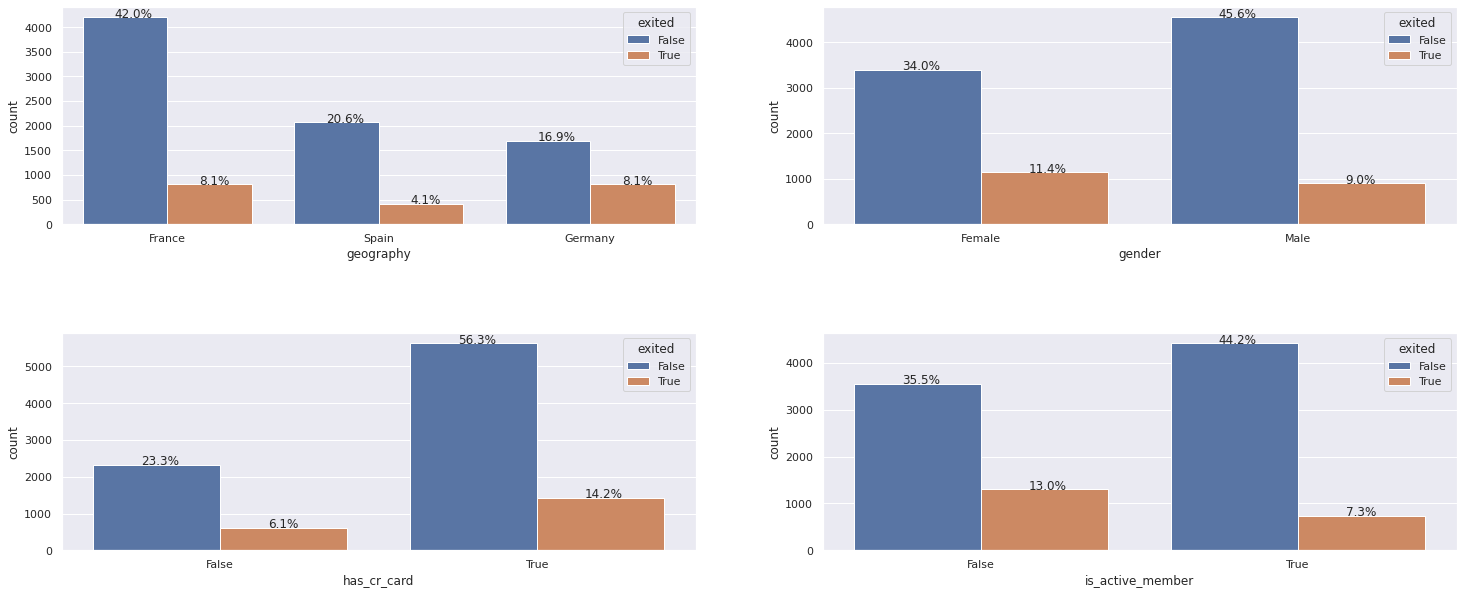

In [26]:
plot_cat_overview(cat_attributes, list(cat_attributes.columns), 'exited') 

In [27]:
categorical_descriptive_statstical(cat_attributes , 'geography')

,absolute,percent %
France,5014,50.140
Germany,2509,25.090
Spain,2477,24.770


In [28]:
categorical_descriptive_statstical(cat_attributes , 'gender')

,absolute,percent %
Male,5457,54.570
Female,4543,45.430


In [29]:
categorical_descriptive_statstical(cat_attributes , 'has_cr_card')

,absolute,percent %
True,7055,70.550
False,2945,29.450


In [30]:
categorical_descriptive_statstical(cat_attributes , 'is_active_member')

,absolute,percent %
True,5151,51.510
False,4849,48.490


In [31]:
categorical_descriptive_statstical(cat_attributes , 'exited')

,absolute,percent %
False,7963,79.630
True,2037,20.370


### 1.5.3. Multivariate Analysis



<AxesSubplot:>

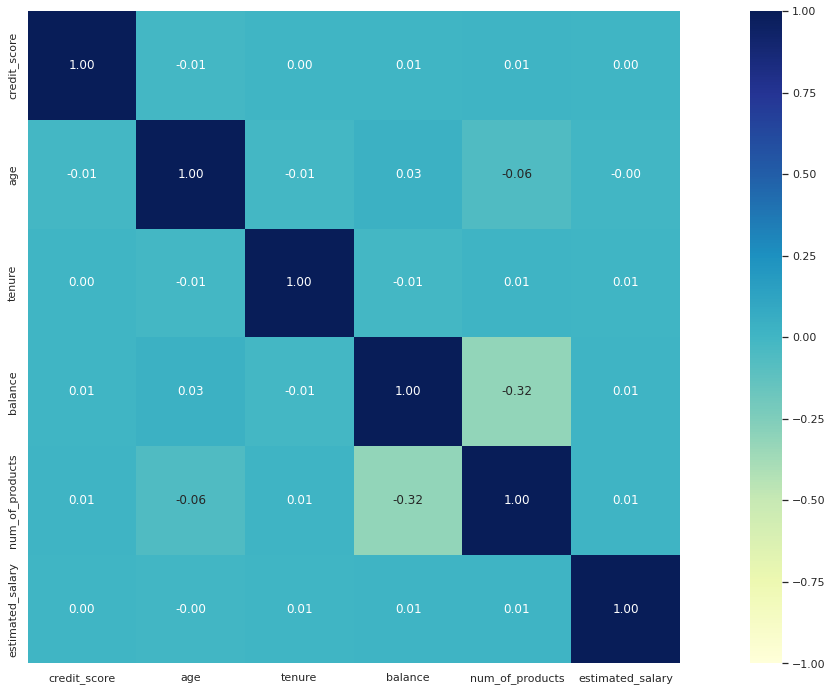

In [32]:
correlation_matrix(df1 , 'spearman')

### 1.5.4. Outliers Numerical Attributes


In [33]:
num_cols = num_attributes.columns.tolist()

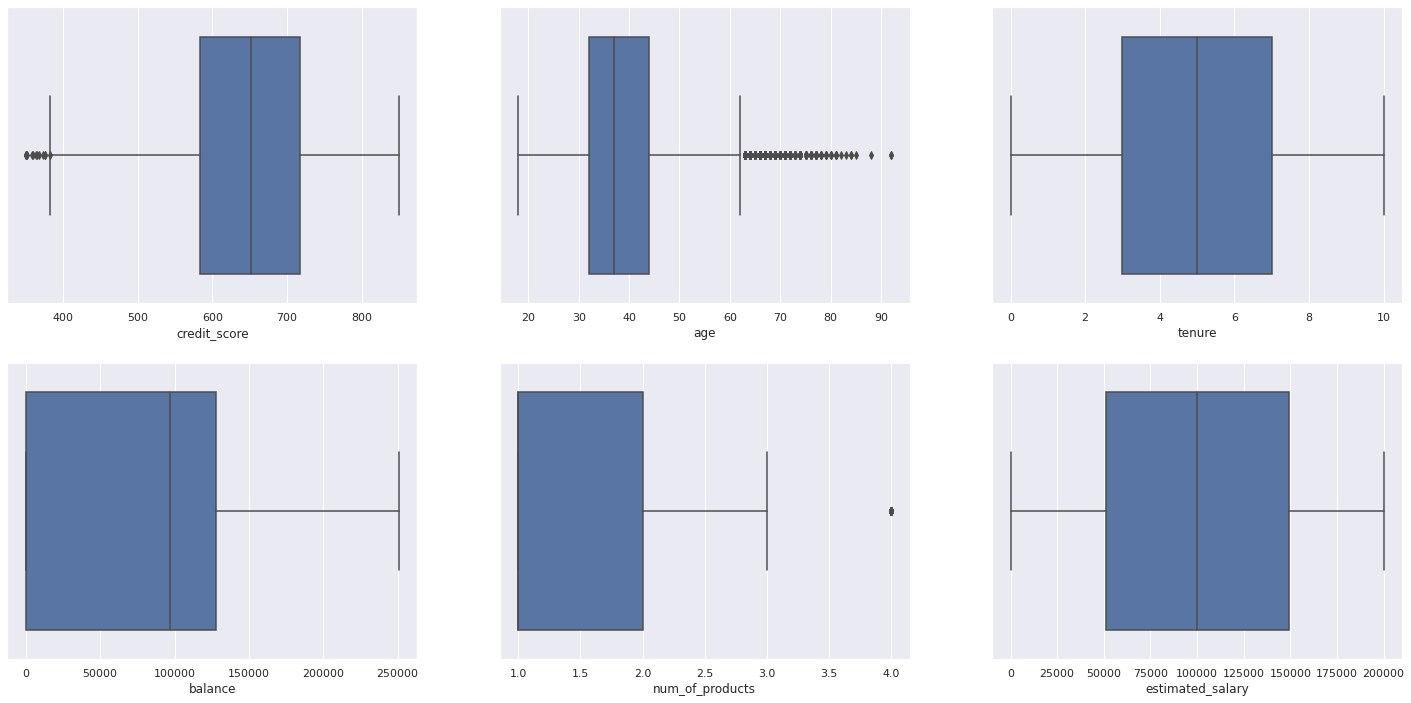

In [34]:
i = 1
for col in df1[num_cols]:
    plt.subplot(2,3,i)
    ax = sns.boxplot( data = df1 , x = col)
    i += 1
    

 **Important informations:**
 
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**
- **70.6%** of the members **has credit card**
- More than **50% of the clients** are **from France**

# 2.0. Feature Engineering


In [35]:
df2 = df1.copy()

In [36]:
df2.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.000,1,True,True,101348.880,True
1,608,Spain,Female,41,1,83807.860,1,False,True,112542.580,False
2,502,France,Female,42,8,159660.800,3,True,False,113931.570,True
3,699,France,Female,39,1,0.000,2,False,False,93826.630,False
4,850,Spain,Female,43,2,125510.820,1,True,True,79084.100,False


## 2.1. Balance_age

In [37]:
# balance_per_age
balance_age = df2[['balance', 'age']].groupby('age').mean().reset_index()
balance_age.columns = ['age' , 'balance_age']

# merge

df2 = pd.merge(df2, balance_age, on = 'age' ,  how = 'left')

## 2.2. Balance_country


In [38]:
balance_country = df2.loc[:, ['geography', 'balance']].groupby('geography').mean().reset_index()
balance_country.columns = ['geography', 'balance_per_country']

# merge
df2 = pd.merge(df2, balance_country, on = 'geography', how = 'left')

## 2.3. Balance_tenure


In [39]:
balance_tenure = df2.loc[:, ['tenure', 'balance']].groupby('tenure').mean().reset_index()
balance_tenure.columns = ['tenure', 'LTV']

# merge
df2 = pd.merge(df2, balance_tenure, on = 'tenure', how = 'left')

## 2.3. Salary_gender


In [40]:
estimated_salary_gender = df2.loc[:, ['gender', 'estimated_salary']].groupby('gender').mean().reset_index()
estimated_salary_gender.columns = ['gender', 'estimated_salary_per_gender']

# merge
df2 = pd.merge(df2, estimated_salary_gender, on = 'gender', how = 'left')

<AxesSubplot:>

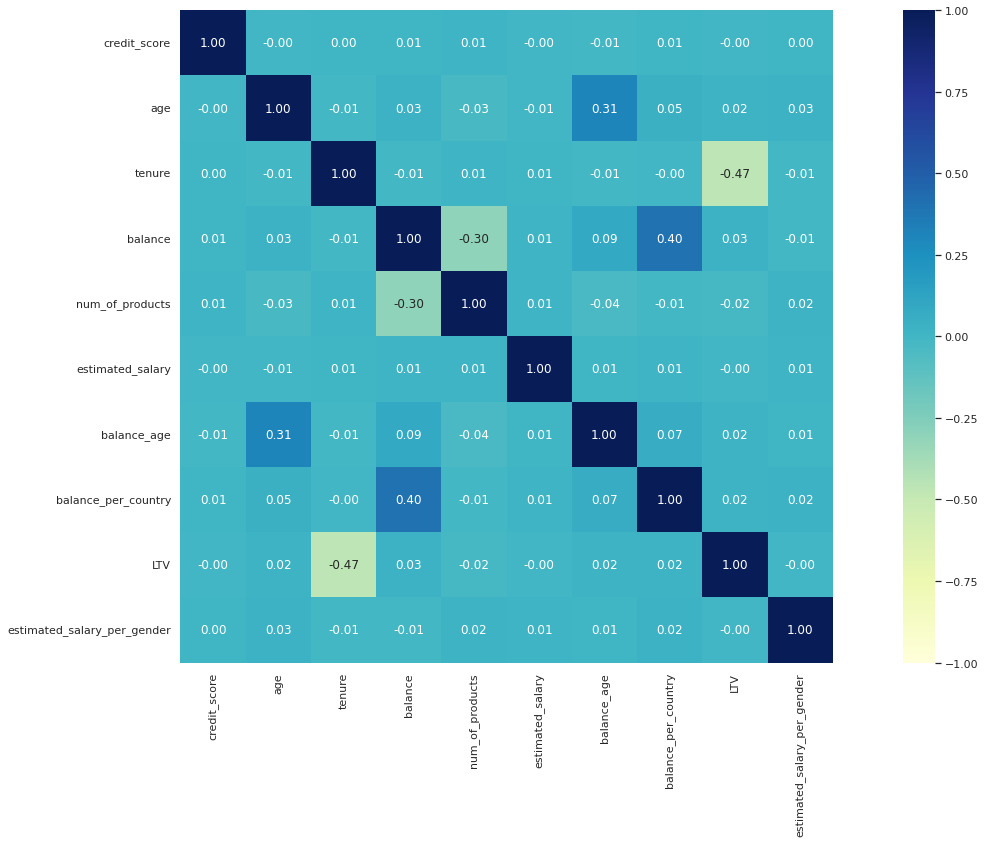

In [41]:
correlation_matrix(df2, 'pearson')

# 3.0. Data Filtering


In [42]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis (EDA)


In [43]:
df4 = df3.copy()

# 5.0. Data Preparation


In [77]:
df5 = df4.copy()

In [78]:
df5.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'balance_age', 'balance_per_country',
       'LTV', 'estimated_salary_per_gender'],
      dtype='object')

In [81]:
df5.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_age,balance_per_country,LTV,estimated_salary_per_gender,country_France,country_Germany,country_Spain,gender_0,gender_1
0,619,42,2,-0.761,1,NaN,NaN,0.012,NaN,76785.312,62092.637,0.131,100601.541,1,0,0,0,1
1,608,41,1,-0.105,1,NaN,NaN,0.126,NaN,75742.975,61818.148,0.942,100601.541,0,0,1,0,1
2,502,42,8,0.489,3,NaN,NaN,0.140,NaN,76785.312,62092.637,0.649,100601.541,1,0,0,0,1
3,699,39,1,-0.761,2,NaN,NaN,-0.065,NaN,74285.289,62092.637,0.942,100601.541,1,0,0,0,1
4,850,43,2,0.222,1,NaN,NaN,-0.215,NaN,81636.038,61818.148,0.131,100601.541,0,0,1,0,1


In [80]:
mms = pp.MinMaxScaler()
rbs = pp.RobustScaler()



#Balance
df5['balance'] = rbs.fit_transform(df5[['balance']].values)

#EstimatedSalary
df5['estimated_salary'] = rbs.fit_transform(df5[['estimated_salary']].values)

#LTV
df5['LTV'] = rbs.fit_transform(df5[['LTV']].values)

#gender - label encoding 
gender_dict = { 'Male':0 , 'Female':1 }
df5['gender'] = df5['gender'].map( gender_dict ) 

#Geography - One Hot Encoding
# one hot encoding encoding 
df5 = pd.get_dummies(df5, prefix=['country'], columns=['geography'])
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender'])

questions_encoding = {'True': 1,'False': 0}
df5['is_active_member'] = df5['is_active_member'].map(questions_encoding ,'is_active_member' )
df5['has_cr_card'] = df5['has_cr_card'].map(questions_encoding)
df5['exited'] = df5['exited'].map(questions_encoding)


# 6.0. Feature Selection


In [69]:
df6 = df5.copy()

In [70]:
x = df6.drop(['exited'], axis =1)
y = df6.exited

In [71]:
y

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9995   NaN
9996   NaN
9997   NaN
9998   NaN
9999   NaN
Name: exited, Length: 10000, dtype: float64

# 7.0. Machine Learning Modelling


In [ ]:
df7 = df6.copy()

# 8.0. Performance Metrics


In [ ]:
df8 = df7.copy()

# 9.0. Deploy to Production


In [ ]:
df9 = df8.copy()